In [52]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import datetime

import os
dfo=pd.DataFrame()

for f in os.listdir('./DataSource/HeyTea/'):
    # if any(i in f for i in ['2021']):
    if f.replace('.csv','').replace('heytea.wxapp_','')>='2023-01-12':
        print(f)
        date=f.split('_')[-1].split('.')[0]
        d=pd.read_csv('./DataSource/HeyTea\%s' % f)
        dfo=pd.concat([dfo,d],axis=0)

old=pd.read_hdf(r'Processed_Data/heytea.h5',key='1227')
new=pd.concat([old,dfo])
new=new.drop_duplicates()
new.to_hdf(r'Processed_Data/heytea.h5',key='1227')


c1=new['抓取时间'].isin(['抓取时间'])
new=new[~c1]
new['datetime']=pd.to_datetime(new['抓取时间'])
new['hour']=new['datetime'].dt.hour
new['date']=new['datetime'].dt.date
new['城市']=new['城市'].str.replace('市',"")

heytea.wxapp_2023-01-12.csv
heytea.wxapp_2023-01-13.csv
heytea.wxapp_2023-01-14.csv
heytea.wxapp_2023-01-15.csv
heytea.wxapp_2023-01-16.csv
heytea.wxapp_2023-01-17.csv


In [53]:
df=new.copy()
stores=df[['ID', '城市', '区域', '门店名称', '地址','date']].drop_duplicates().sort_values(by='date')
#选取2021年2月春节后营业的店铺
c1=stores.date.astype('str')=='2021-02-23'
c2=stores.date.astype('str')=='2023-01-12'
samestore=stores[c1].merge(stores[c2],on='ID',how='inner')['ID']
df=df[df.ID.isin(samestore)]

df['等待杯量']=pd.to_numeric(df['等待杯量'])
ht=df.groupby(by=['date','城市','ID'])['等待杯量'].mean().reset_index() #hourly avg
ht=ht.groupby(by=['date','城市'])['等待杯量'].sum().reset_index() #hourly sum
ht['等待杯量']=ht['等待杯量']*14
ht['杯量_last7d_mean']=ht.groupby('城市')['等待杯量'].transform(lambda x: x.rolling(7, 7).mean())
ht

,date,城市,等待杯量,杯量_last7d_mean
0,2020-09-23,上海,27798.0,NaN
1,2020-09-23,东莞,2168.0,NaN
2,2020-09-23,中山,931.0,NaN
3,2020-09-23,佛山,3887.0,NaN
4,2020-09-23,兰州,1237.0,NaN
...,...,...,...,...
25879,2023-01-17,镇江,0.0,618.153846
25880,2023-01-17,长沙,63.0,2258.197802
25881,2023-01-17,阳江,0.0,568.846154
25882,2023-01-17,青岛,28.0,2657.219780


In [54]:
#选取2022年营业大于360天的店铺
# c2=df['date']>=datetime.date(2021,12,20)
# df=df[c2].sort_values(by=['date'])
# storelist=df.groupby(by=['hour','地址'])['ID'].count().reset_index().groupby(by='地址')['ID'].mean().reset_index()
# storelist=storelist[storelist['ID']>360]['地址']
# df=df[df['地址'].isin(storelist)]


#计算相对1Q21的平均
c1=ht['date']<= datetime.date(2022,3,31)
c2=ht['date']>= datetime.date(2022,1,1)
c3=~ht['date'].astype('str').isin(['2022-01-31','2022-02-01','2022-02-02','2022-02-03','2022-02-04','2022-02-05','2022-02-06'])
Mar_mean=ht[c1&c2&c3].groupby('城市').mean().reset_index().sort_values(by='等待杯量')[['城市','等待杯量']].reset_index(drop=True)
Mar_mean.columns=['城市', '等待杯量_mar']
ht=ht.merge(Mar_mean,on='城市')
ht['changes_since_mar']=ht['杯量_last7d_mean']/ht['等待杯量_mar']

#计算WoW 以及相对22年同期的平均
ht['杯量_change_WoW']=(ht['杯量_last7d_mean']/ht.groupby('城市')['杯量_last7d_mean'].transform(lambda x: x.shift(periods=7)))-1

ht['date']=ht['date'].astype('string') 

def getdt(d):
    return str(d)[-5:]
ht['dt']=ht['date'].apply(getdt)

c1=ht['date'].str.contains('2022')
ht_22=ht[c1]
ht_22=ht_22[['城市', 'dt','杯量_last7d_mean']]
ht_22=ht_22.rename(columns={'杯量_last7d_mean':'杯量_22_rolling_mean'})

c2=ht['date'].str.contains('2023')
ht_23=ht[c2]
ht_23=ht_23.merge(ht_22,how='left',on=['城市','dt'])

ht_23['ht_status']=ht_23['杯量_last7d_mean']/ht_23['杯量_22_rolling_mean']


<AxesSubplot: >

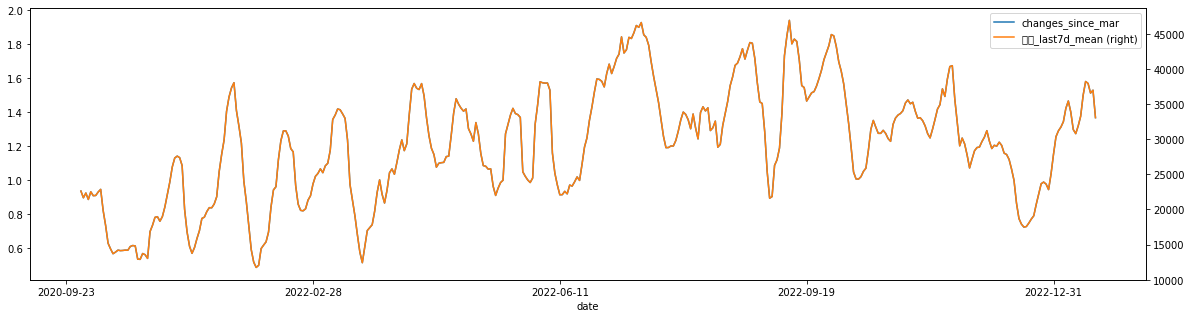

In [55]:
dfp=ht[ht['城市']=='深圳']
ax = dfp.plot('date','changes_since_mar')
dfp.plot('date','杯量_last7d_mean',secondary_y=True, ax=ax, figsize=(20,5))
# dfp.plot('date','杯量_last7d_mean', figsize=(20,5))

In [56]:
citydate=pd.read_hdf('Processed_Data/amap.h5',key='noCOVIDdf')
citydate.tail(2)

,城市,date,traffic,WeekDay,yr,dt,mon,traffic_19_same_wd_mean,amapCNY19_last7d_mean,traffic_last7d_mean,traffic_change,traffic_status_old,traffic_status_last7d_mean,CityTier,yrmon,城市date
46027,张家口,2023-01-15,1.38,Sunday,2023,01-15,01,1.405,1.501429,1.501429,0.091381,1.068632,1.000000,四线城市,2023-01,张家口2023-01-15
46028,韶关,2023-01-15,1.35,Sunday,2023,01-15,01,1.405,1.470000,1.442857,0.058700,1.026945,0.981535,四线城市,2023-01,韶关2023-01-15


In [57]:
#计算相对1Q21 无疫情 非春节时间的平均
c1=ht['date'].astype('str') <= '2022-03-31'
c2=ht['date'].astype('str') >= '2022-01-01'
c3=~ht['date'].astype('str').isin(['2022-01-31','2022-02-01','2022-02-02','2022-02-03','2022-02-04','2022-02-05','2022-02-06'])
noCovid_mean=ht[c1&c2&c3]

noCovid_mean['城市date']=noCovid_mean['城市']+noCovid_mean['date']
c4=noCovid_mean['城市date'].isin(citydate['城市date'])
noCovid_mean=noCovid_mean[c4].groupby('城市').mean().reset_index().sort_values(by='等待杯量',ascending=False)[['城市','等待杯量']].reset_index(drop=True).rename(columns={'等待杯量':'等待杯量1Q22无疫情日平均'})
noCovid_mean.head(4)

,城市,等待杯量1Q22无疫情日平均
0,上海,37958.867295
1,广州,24793.848970
2,深圳,24061.549362
3,北京,23642.681613


In [69]:
htall=ht.copy()
htall=htall.fillna(0)
htall=htall.merge(noCovid_mean,on='城市',how='left')
htall=htall[htall['等待杯量1Q22无疫情日平均']>0]
htall=htall[htall.date.astype('str')>='2022-12-01'].groupby('date').sum().reset_index()#.plot('date','changes_since_mar', figsize=(20,5))
htall['等待杯量_change']=htall['杯量_last7d_mean']/htall['等待杯量1Q22无疫情日平均']
htall[['date','等待杯量_change']].to_clipboard(index=False)

<AxesSubplot: xlabel='date'>

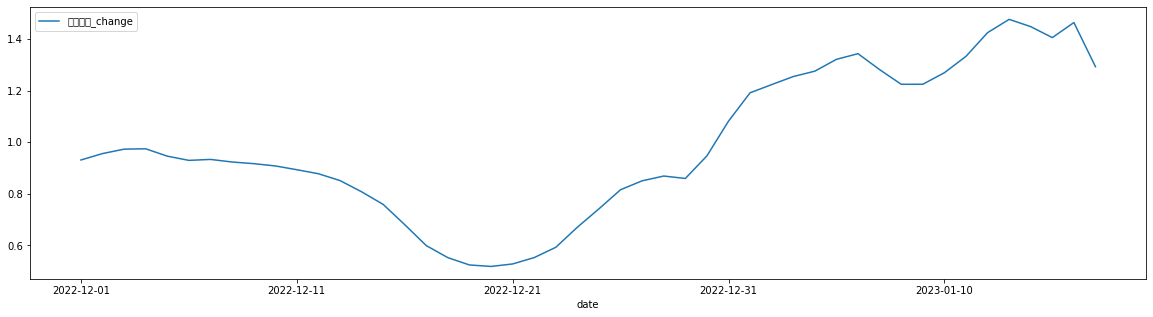

In [68]:
htall.plot('date','等待杯量_change', figsize=(20,5))

In [59]:
# # covid rank vs. HEYTEA WoW

# %load_ext autoreload
# %autoreload 2
# from colored_list import dafeng_city,jidui_city,riqi
# # riqi='2022-12-29'
# df_covid=pd.read_hdf('Processed_Data/Baidu_covid_progress.h5',key='raw')

# ht1=ht_23.merge(df_covid,left_on=['城市'],right_on=['城市'],how='left')

# ht1['date']=ht1['date'].astype('string') 

# ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)
# ht2=ht2[ht1['杯量_change_WoW']<4].head(100).reset_index()

# o=ht2[['城市',  'progress_2','杯量_change_WoW']]

# o['size']=np.nan
# o['group']='其他'

# c1=o['城市'].isin(dafeng_city)
# o.loc[c1,'group']='本波疫情基本结束'

# o=o.sort_values(by='group',ascending=False)
# o.to_clipboard(index=False,header=None)
# print(riqi,'wow')

In [60]:
# ht['date']=ht['date'].astype('str')
# c1=ht['date'].isin(['2022-01-01','2022-01-02','2022-01-03'])
# c2=ht['date'].isin(['2022-12-31','2023-01-01','2023-01-02'])
# d1=ht[c1][['城市','等待杯量']].groupby('城市').mean().reset_index().rename(columns={'等待杯量':'2022元旦平均杯量'})
# d2=ht[c2][['城市','等待杯量']].groupby('城市').mean().reset_index().rename(columns={'等待杯量':'2023元旦平均杯量'})
# d3=d1.merge(d2,on='城市')
# d3['changes_since_mar']=d3['2023元旦平均杯量']/d3['2022元旦平均杯量']
# d3

In [61]:
# # covid rank vs. heytea as of 2022

# ht1=ht_23.merge(df_covid,left_on=['城市'],right_on=['城市'],how='left') #regular update

# ht1['date']=ht1['date'].astype('string') 
# ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)

# ht2=ht2[ht1['ht_status']<10].head(100).reset_index()
# o=ht2[['城市',  'progress_2','ht_status']]

# o['size']=np.nan
# o['group']='其他'

# c1=o['城市'].isin(dafeng_city)
# o.loc[c1,'group']='本波疫情基本结束'

# o=o.sort_values(by='group',ascending=False)

# o.to_clipboard(index=False,header=None)



# print(riqi,'同比')
# print(o)


In [71]:
# 人均收入 vs. HEYTEA WoW

%load_ext autoreload
%autoreload 2
from colored_list import dafeng_city,jidui_city,riqi
riqi='2023-01-16'


city_popu=pd.read_hdf('Processed_Data/citypopu.h5',key='raw2')

ht1=ht_23.merge(city_popu,on='城市',how='left')

ht1['date']=ht1['date'].astype('string') 

ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)
ht2=ht2[ht1['杯量_change_WoW']<0.7].head(100).reset_index()

o=ht2[['城市',  '人均可支配收入','杯量_change_WoW']]

o['size']=np.nan
o['group']='其他'

c1=o['城市'].isin(dafeng_city)
o.loc[c1,'group']='本波疫情基本结束'

o=o.sort_values(by=['group','人均可支配收入'],ascending=False)

o.to_clipboard(index=False,header=None)
print(riqi,'wow')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-01-16 wow


In [74]:
# 人均收入 vs. HEYTEA as of 2022

# riqi='2023-01-09'
ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)
ht2=ht2[ht1['changes_since_mar']<3].sort_values(by='常住人口',ascending=False).head(70).reset_index()

o=ht2[['城市',  '人均可支配收入','changes_since_mar']]

o['size']=np.nan
o['group']='其他'

c1=o['城市'].isin(dafeng_city)
o.loc[c1,'group']='本波疫情基本结束'

o=o.sort_values(by=['group','人均可支配收入'],ascending=False)

d=ht1[ht1['date']==riqi][['城市','date','changes_since_mar']].reset_index(drop=True).rename(columns={'date':'date','changes_since_mar':'heytea'})
d['date']=pd.to_datetime(d['date'])
d.to_hdf('Processed_Data/city_compare.h5',key='heytea')

o.to_clipboard(index=False,header=None)
print(riqi,'as of')

2023-01-16 as of


In [77]:
# d1=pd.read_clipboard()
# d1.to_hdf('Processed_Data/tablehead.h5','heytea')

d1=pd.read_hdf('Processed_Data/tablehead.h5','heytea')
d2=pd.pivot_table(ht[ht['date'].astype('str')>='2023-01-12'],index='城市',columns='date',values='等待杯量',aggfunc='mean').reset_index()
d1.merge(d2,left_on='城市',right_on='城市',how='left').drop(columns='城市').to_clipboard(index=False)